# Demand Forecasting- using temperature and timeseries features as factors
In this experiment we use *'totaldemand'* and *'temperature'* dataset. Our target variable is TOTALDEMAND and inputs are the timeseries features based on time series index and TEMPERATURE.


#### Import necessary libraries

In [2]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px 

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV

#from sklearn.impute import SimpleImputer
#from sklearn.pipeline import make_pipeline
#from window_ops.rolling import rolling_mean, rolling_max, rolling_min

import warnings
warnings.filterwarnings("ignore")

#### Read the merged data of totaldemand and temperature

In [3]:
# read the data into a dataframe
demand_temp_df = pd.read_csv('../../../data/demand_temp.csv')

# convert 'DATETIME' to  datetime 
demand_temp_df['DATETIME'] = pd.to_datetime(demand_temp_df['DATETIME'])


#### Create some functions

In [4]:
# root mean squared error (rsme)
def rmse(pred, actual): 
	return np.sqrt(((pred-actual)**2).mean())

# mean absolute percentage error (mape)
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Create time series features based on time series index
def create_features(df):
    df['YEAR'] = df.index.year
    df['MONTH'] = df.index.month
    df['DAY_OF_WEEK'] = df.index.dayofweek
    df['DAY'] = df.index.day
    df['HOUR'] = df.index.hour
    df['HALF_HOUR'] = df.index.minute//30
    
    return df

#### Set DATETIME as index

In [5]:
# Set DATETIME feature as index
demand_temp_df_copy = demand_temp_df.copy()
demand_temp_idx = demand_temp_df_copy.set_index('DATETIME')

#### Create timeseries features

In [6]:
demand_temp_features = demand_temp_idx.copy()
demand_temp_features = create_features(demand_temp_features)

## Forecasting using Machine Learning

#### Split the data into train and test

In [7]:
data_inputx = demand_temp_features.drop(['TOTALDEMAND'], axis=1)
data_inputy = demand_temp_features['TOTALDEMAND']

x_train = data_inputx[data_inputx.index.get_level_values(0) < '2021-01-01']
y_train = data_inputy[data_inputy.index.get_level_values(0) < '2021-01-01']

x_test = data_inputx[data_inputx.index.get_level_values(0) >= '2021-01-01']
y_test = data_inputy[data_inputy.index.get_level_values(0) >= '2021-01-01']


### Forecasting by using Linear Regression

In [8]:
lr = LinearRegression()
lr.fit(x_train,y_train)

y_pred_train = lr.predict(x_train)
y_pred_test1 = lr.predict(x_test)

train_acc_rmse = rmse( y_pred_train, y_train) 
test_acc_rmse = rmse( y_pred_test1, y_test)

train_acc_mae = mean_absolute_error(y_train, y_pred_train)
test_acc_mae = mean_absolute_error( y_test,  y_pred_test1)

train_acc_mape = mape(y_train, y_pred_train) 
test_acc_mape = mape(y_test, y_pred_test1)

print("Train RMSE:",train_acc_rmse) # 1080.7066022799468
print("Test RMSE:",test_acc_rmse)   # 1146.0637412751905

print("Train MAE:",train_acc_mae ) # 855.5326231842424
print("Test MAE:",test_acc_mae)    # 883.4159118948148

print("Train MAPE:",train_acc_mape) # 10.606358729570678
print("Test MAPE:",test_acc_mape)   # 11.422453867989018

# create a summary table
columns = ['Data', 'Model', 'MAPE', 'MAE', 'RMSE']
metrics = pd.DataFrame(columns = columns)
metrics.loc[0] = ['test','Linear Regression', test_acc_mape, test_acc_mae, test_acc_rmse]
metrics

Train RMSE: 1080.7066022799465
Test RMSE: 1146.0637412751908
Train MAE: 855.5326231842452
Test MAE: 883.4159118948228
Train MAPE: 10.606358729570763
Test MAPE: 11.422453867989207


,Data,Model,MAPE,MAE,RMSE
0,test,Linear Regression,11.422454,883.415912,1146.063741


#### How well fits our model

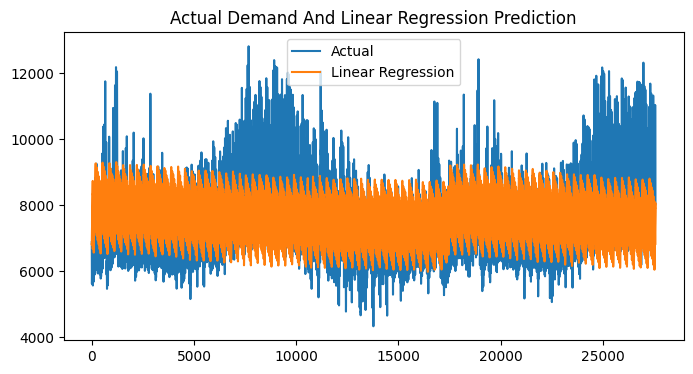

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_test1, label='Linear Regression')
plt.title('Actual Demand And Linear Regression Prediction')
plt.legend()

### Forecasting by using neural network (Multi-Layer Perceptron)

In [11]:
mlp = MLPRegressor(hidden_layer_sizes=(12, ), activation='relu', solver='adam', random_state=1, alpha=0.1,max_iter=500, learning_rate_init = 0.1, tol=0)
mlp.fit(x_train,y_train)

y_pred_train = mlp.predict(x_train)
y_pred_test2 = mlp.predict(x_test)

train_acc_rmse = rmse( y_pred_train, y_train) 
test_acc_rmse = rmse( y_pred_test2, y_test)

train_acc_mae = mean_absolute_error(y_train, y_pred_train)
test_acc_mae = mean_absolute_error( y_test,  y_pred_test2)

train_acc_mape = mape(y_train, y_pred_train) 
test_acc_mape = mape(y_test, y_pred_test2)

print("Train RMSE:",train_acc_rmse) # 1117.268082977708
print("Test RMSE:",test_acc_rmse) # 1222.4129470896246

print("Train MAE:",train_acc_mae ) # 887.5409415268394
print("Test MAE:",test_acc_mae)    # 1007.22934442299

print("Train MAPE:",train_acc_mape) # 10.899920868153986
print("Test MAPE:",test_acc_mape) # 13.72068107349497

metrics.loc[1] = ['test','Multi-Layer Perceptron', test_acc_mape, test_acc_mae, test_acc_rmse]
metrics

Train RMSE: 1117.2680825809769
Test RMSE: 1222.412949888548
Train MAE: 887.5409395314834
Test MAE: 1007.2293467511882
Train MAPE: 10.8999208345137
Test MAPE: 13.720681084102296


,Data,Model,MAPE,MAE,RMSE
0,test,Linear Regression,11.422454,883.415912,1146.063741
1,test,Multi-Layer Perceptron,13.720681,1007.229347,1222.412950


#### How well fits our model

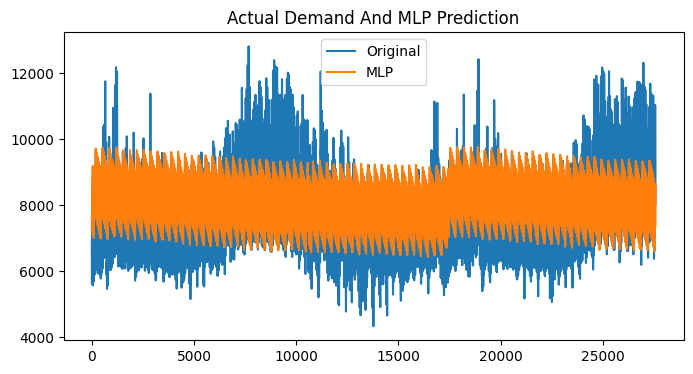

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Original')
plt.plot(y_pred_test2, label='MLP')
plt.title('Actual Demand And MLP Prediction')
plt.legend()

#### Plot spread of predictions vs. actuals

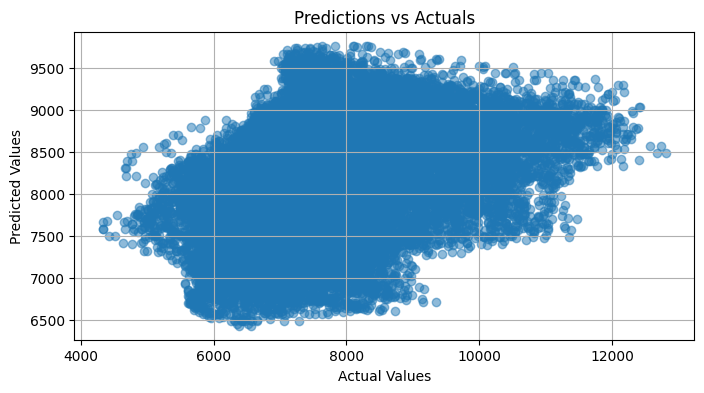

In [13]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred_test2, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actuals')
plt.grid(True)
plt.show()

### Forecasting by using Random Forest

In [14]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
}

rf = RandomForestRegressor(random_state=1)
best_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

best_rf.fit(x_train, y_train)

y_pred_train = best_rf.predict(x_train)
y_pred_test3 = best_rf.predict(x_test)

train_acc_rmse = rmse( y_pred_train, y_train) 
test_acc_rmse = rmse( y_pred_test3, y_test)

train_acc_mae = mean_absolute_error(y_train, y_pred_train)
test_acc_mae = mean_absolute_error( y_test,  y_pred_test3)

train_acc_mape = mape(y_train, y_pred_train) 
test_acc_mape = mape(y_test, y_pred_test3)

print("Train RMSE:",train_acc_rmse) # 763.936140763187
print("Test RMSE:",test_acc_rmse)   # 1083.928643336924

print("Train MAE:",train_acc_mae ) # 573.8086335718675
print("Test MAE:",test_acc_mae)    # 833.0644637609324

print("Train MAPE:",train_acc_mape) # 6.987174519784377
print("Test MAPE:",test_acc_mape)   # 11.32050569430585

metrics.loc[2] = ['test','Random Forest', test_acc_mape, test_acc_mae, test_acc_rmse]
metrics

Train RMSE: 763.936140763187
Test RMSE: 1083.928643336924
Train MAE: 573.8086335718675
Test MAE: 833.0644637609324
Train MAPE: 6.987174519784377
Test MAPE: 11.32050569430585


,Data,Model,MAPE,MAE,RMSE
0,test,Linear Regression,11.422454,883.415912,1146.063741
1,test,Multi-Layer Perceptron,13.720681,1007.229347,1222.412950
2,test,Random Forest,11.320506,833.064464,1083.928643


#### How well fits our model

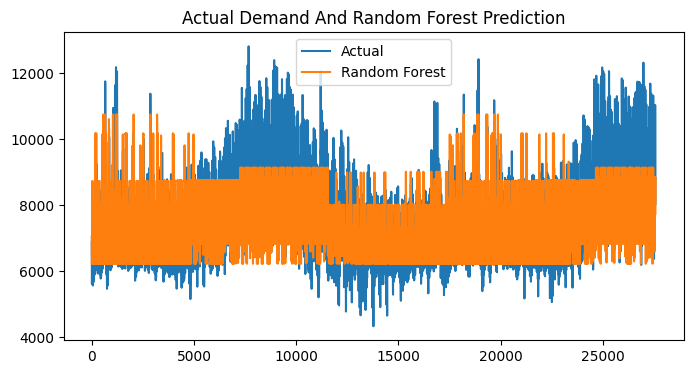

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_test3, label='Random Forest')
plt.title('Actual Demand And Random Forest Prediction')
plt.legend()

### Forecasting by using XGBoost

In [16]:
# Define the hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
xgb = XGBRegressor(random_state=1)
best_xgb = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)

best_xgb.fit(x_train, y_train)

y_pred_train = best_xgb.predict(x_train)
y_pred_test4 = best_xgb.predict(x_test)

train_acc_rmse = rmse( y_pred_train, y_train) 
test_acc_rmse = rmse( y_pred_test4, y_test)

train_acc_mae = mean_absolute_error(y_train, y_pred_train)
test_acc_mae = mean_absolute_error( y_test,  y_pred_test4)

train_acc_mape = mape(y_train, y_pred_train) 
test_acc_mape = mape(y_test, y_pred_test4)

print("Train RMSE:",train_acc_rmse) # 328.5970853464845
print("Test RMSE:",test_acc_rmse) # 539.3668496640918

print("Train MAE:",train_acc_mae ) # 238.24645645328053
print("Test MAE:",test_acc_mae)    # 398.5120657555862

print("Train MAPE:",train_acc_mape) # 2.9120919644043743
print("Test MAPE:",test_acc_mape) # 5.355162755417311

metrics.loc[3] = ['test','XGBoost', test_acc_mape, test_acc_mae, test_acc_rmse]
metrics

Train RMSE: 328.5970853464845
Test RMSE: 539.3668496640918
Train MAE: 238.24645645328053
Test MAE: 398.5120657555862
Train MAPE: 2.9120919644043743
Test MAPE: 5.355162755417311


,Data,Model,MAPE,MAE,RMSE
0,test,Linear Regression,11.422454,883.415912,1146.063741
1,test,Multi-Layer Perceptron,13.720681,1007.229347,1222.412950
2,test,Random Forest,11.320506,833.064464,1083.928643
3,test,XGBoost,5.355163,398.512066,539.366850


#### Feature Importance

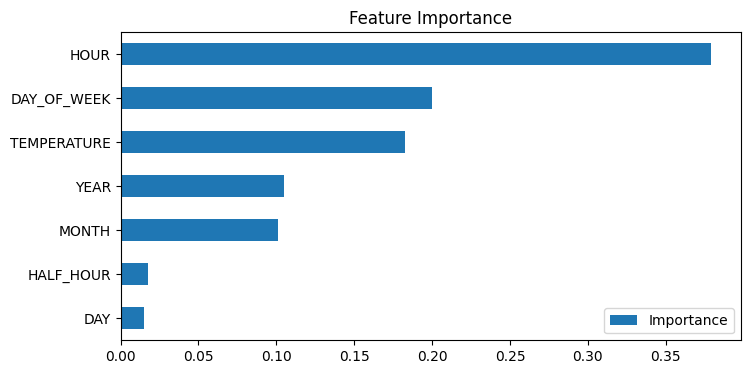

In [17]:
# create a dataframe with feature importances
feature_imp = pd.DataFrame(data=best_xgb.best_estimator_.feature_importances_,
                           index=best_xgb.feature_names_in_,
                          columns=['Importance'])

# plot the features according to their importance
feature_imp.sort_values('Importance').plot(kind='barh', title='Feature Importance', figsize=(8, 4))
plt.show()

### Plot the predicted demand on original demand

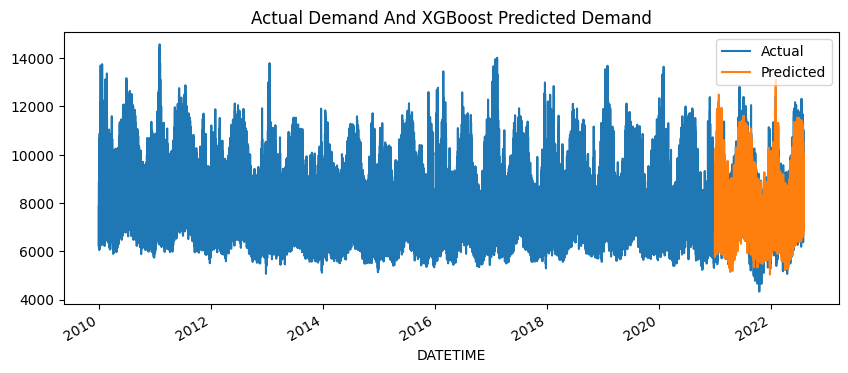

In [18]:
test_df =pd.DataFrame(y_test)
test_df['PREDICTION']= best_xgb.predict(x_test)
df = demand_temp_features.merge(test_df[['PREDICTION']], how = 'left', left_index=True, right_index=True)

# Plot
ax = df[['TOTALDEMAND']].plot(figsize=(10, 4))
test_df['PREDICTION'].plot(ax=ax, style='-')
plt.legend(['Actual', 'Predicted'])
ax.set_title('Actual Demand And XGBoost Predicted Demand')
plt.show()

#### How well XGBoost predict

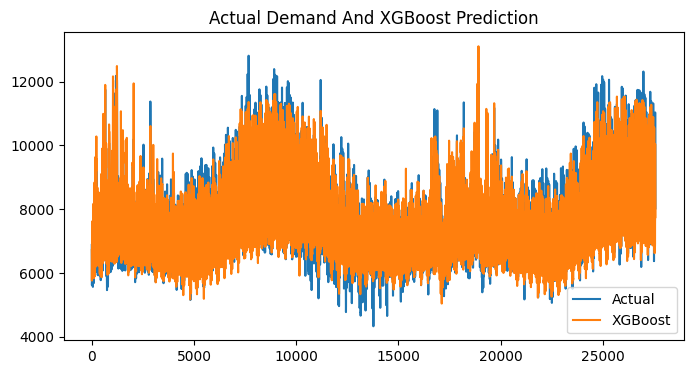

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_test4, label='XGBoost')
plt.title('Actual Demand And XGBoost Prediction')
plt.legend()
plt.show()